In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
data = pd.read_csv('all_items_improved.csv', sep=',')

#### Potential bugs found :
- numbers in the menu item text (meat weight for instance, nb of snails 6/12 + price in the text)
- prices negative (special offers for lunch menus, ..)
- zip codes missing
- comma forgotten in the price (2700 instead of 27,00)

#### Observations : 
- tags only in the first row of each restaurants
- rest_avg_price does not represent the average price of a restaurant item but rather the average price of eating at the restaurant under the opinion of the owner.

## Improving/Debugging the data

### Supressing negative price (special offers on the menu, ex : -1e for lunch)

In [3]:
data = data[data.item_price > 0]

### 'location' feature, switching to zip codes

In [4]:
data['rest_location'] = data['rest_location'].apply(lambda x: x.split("\n")[1].strip())
data['rest_location'] = data['rest_location'].replace('', '0').replace('Bercy Village', '0').astype(int)

In [5]:
data['rest_location'].unique()

array([    0, 75002, 75018, 75015, 75006, 75010, 75017, 75014, 75008,
       75012, 75003, 75011, 75005, 75001, 75007, 75020, 75019, 75004,
       75116, 75013, 75009, 75016])

### Dropping item_prices with prices over 200e 
##### (noise + errors in the comma location most of the times), will only affect a little our predictions for wine and champagne

In [6]:
data = data[data.item_price < 200]

In [7]:
data.index = np.arange(len(data.item))

## Descriptive Statistics

### Dataset Size

In [8]:
print('Number of restaurants: ', data.rest_name.nunique())
print('Number of menu items: ', data.shape[0])

Number of restaurants:  4599
Number of menu items:  80379


### Menu items prices Distribution

In [9]:
data.item_price.describe()[1:].round(1)

mean     13.9
std      13.9
min       0.6
25%       6.0
50%      10.0
75%      16.5
max     199.0
Name: item_price, dtype: float64

Proportion of items < 10€: 49.43%
Proportion of items > 100€: 0.21%


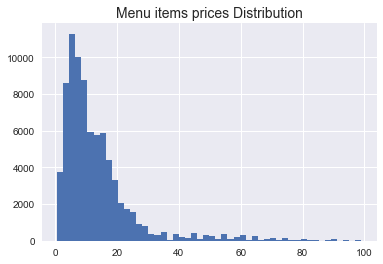

In [10]:
nb_items = float(len(data.item_price))
print('Proportion of items < 10€: {0:.2f}%'.format(100*(data.item_price < 10).sum()/nb_items))
print('Proportion of items > 100€: {0:.2f}%'.format(100*(data.item_price > 100).sum()/nb_items))

a=plt.hist(data[data.item_price < 100].item_price, bins=50)
plt.title('Menu items prices Distribution', fontsize = 14);

### The Fork average prices / ratings

In [11]:
data.drop_duplicates(['rest_name'])[['rest_avg_price', 'rest_global_rating']].describe().round(1)[1:]

,rest_avg_price,rest_global_rating
mean,29.6,8.4
std,18.3,1.0
min,9.0,2.0
25%,20.0,8.1
50%,25.0,8.6
75%,34.0,9.0
max,330.0,10.0


### Price disparities between locations

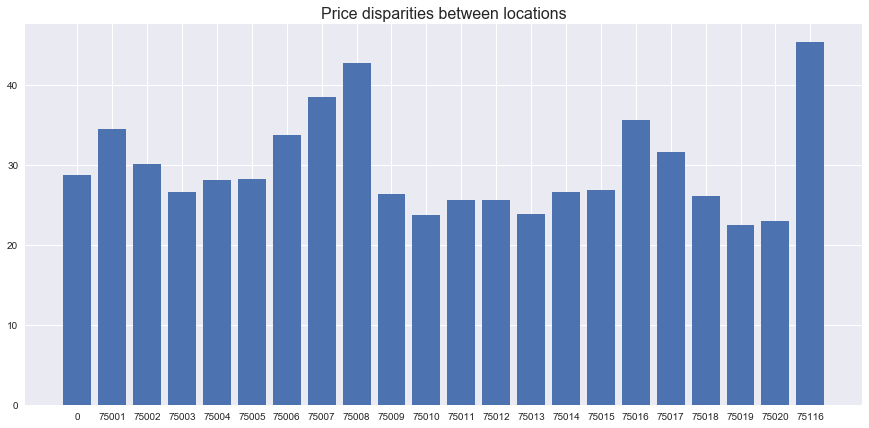

In [12]:
df = data.groupby(data.rest_name).first()
price_location = df.groupby(df.rest_location).rest_avg_price.mean()

x_axis = range(len(price_location))
big_fig = plt.figure(1, figsize=(15,7))
fig = plt.subplot(111)
fig.bar(x_axis, price_location.values)
fig.set_xticks(x_axis)
fig.set_xticklabels(price_location.index)
fig.set_title('Price disparities between locations', fontsize=16)
plt.show();

### Price standard deviation per restaurant

In [13]:
print('Std of the prices inside a restaurant: ', data.groupby(data.rest_name).item_price.std().mean(), '€')

Std of the prices inside a restaurant:  11.300018428428515 €


### Statistics on the nb of words in the items' texts

In [14]:
data['item_length'] = data['item'].apply(lambda x: len(x.split()))
data['item_length'].describe()[1:]

mean     5.241991
std      4.034759
min      1.000000
25%      3.000000
50%      4.000000
75%      7.000000
max     46.000000
Name: item_length, dtype: float64

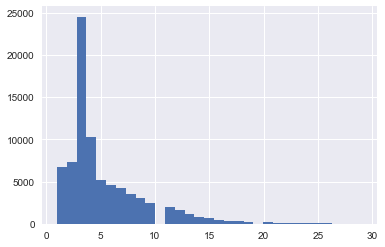

In [15]:
data[data.item_length<30].item_length.hist(bins = 31);

### Handling tags 

In [16]:
data.head()

,rest_name,item,item_price,rest_url,rest_global_rating,rest_avg_price,rest_location,rest_tags,item_length
0,Les Garcons Bouchers,Bruschetta Foie de Volaille sur nid de Roquett...,10.0,https://www.lafourchette.com/restaurant/les-ga...,8.6,36.0,0,"['Français', 'Bistrot', 'Entre amis', 'Anniver...",12
1,Les Garcons Bouchers,Planche de charcuteries (à partager à 2 ou 3 p...,25.0,https://www.lafourchette.com/restaurant/les-ga...,8.6,36.0,0,[],10
2,Les Garcons Bouchers,Poêlé de Foie de Volaille sur Nid de Roquette,14.0,https://www.lafourchette.com/restaurant/les-ga...,8.6,36.0,0,[],9
3,Les Garcons Bouchers,Le Hamburger Rossini 200 gr,26.0,https://www.lafourchette.com/restaurant/les-ga...,8.6,36.0,0,[],5
4,Les Garcons Bouchers,La côte de Bœuf ~ 500 gr,33.0,https://www.lafourchette.com/restaurant/les-ga...,8.6,36.0,0,[],7


In [17]:
from ast import literal_eval
data.rest_tags = data.rest_tags.apply(literal_eval)


In [18]:
tags =  data.drop_duplicates(['rest_name']).rest_tags

all_tags =  set.union(*map(set, tags))
print("Number of different tags: ", len(all_tags))
print("Tag properties: \n")
tags.apply(lambda l: len(set(l))).describe()[1:]

Number of different tags:  243
Tag properties: 



mean    11.273755
std      3.051121
min      5.000000
25%      9.000000
50%     11.000000
75%     13.000000
max     38.000000
Name: rest_tags, dtype: float64

In [19]:
from collections import Counter
most_frequent = Counter()

for item in tags:
    most_frequent.update(set(item))
    
most_frequent.most_common(25)

[('...', 4599),
 ('Île-de-France', 4597),
 ('Français', 4140),
 ('Traditionnel', 2240),
 ('Italien', 1976),
 ("Certificat d'Excellence TripAdvisor 2017", 1318),
 ('Paris - Centre', 1192),
 ('Les mieux notés', 856),
 ('Bistrot', 843),
 ('Plats végétariens', 840),
 ('Branché', 749),
 ('Japonais', 644),
 ('Indien', 640),
 ('World food', 624),
 ('Opéra - Grands Boulevards', 595),
 ('Asiatique', 500),
 ('Américain', 481),
 ('Thailandais', 466),
 ('Chinois', 457),
 ('Brasserie', 393),
 ('Libanais', 393),
 ('Bastille', 390),
 ('Anniversaire', 371),
 ('Paris 9ème', 368),
 ('Crêperie', 360)]

In [20]:
# Remove "..."
most_frequent_tags = [i[0] for i in most_frequent.most_common(25)[1:]]
# Build the lists


In [21]:
lengths = data.rest_name.value_counts().to_dict()
has_tags = {tag: [] for tag in most_frequent_tags}
for  _, (rest, tags_list) in data.drop_duplicates(['rest_name'])[['rest_name', 'rest_tags']].iterrows():
    length = lengths[rest]
    for tag in most_frequent_tags:
        if tag in tags_list:
            has_tags[tag].extend([1]*length)
        else:
            has_tags[tag].extend([0]*length)

In [22]:
for tag, values in has_tags.items():
    data[tag] = values

In [23]:
# Black magic ahead
n_tags_col = []
for rest, n_tags in zip(data.rest_name.drop_duplicates(), tags.apply(lambda l: len(set(l)))):
    n_tags_col.extend([n_tags] * lengths[rest])
data["n_tags"] = n_tags_col

### Machine learning wizardry

#### We are now writing in data_ml because we're doing transformations which suck for visualization
#### Anything that helps visualization should go above and also change data

In [24]:
from sklearn.preprocessing import LabelEncoder


data_ml = data.drop(["rest_url", "rest_tags"], axis=1).copy()
rest_name = LabelEncoder()
rest_name.fit(data_ml.rest_name)
data_ml.rest_name = rest_name.transform(data_ml.rest_name)

In [25]:
def restaurantKfold(n_splits=5, shuffle=True):
    length = data_ml.rest_name.nunique()
    restaurants = data_ml.rest_name.unique()
    if shuffle:
        np.random.shuffle(restaurants)
    for i in range(n_splits):
        test = restaurants[int(length*i/n_splits):int(length*(i+1)/n_splits)]
        mask = data_ml.rest_name.isin(test)
        yield ~mask, mask

### Without the main source of information : the menu item text

In [26]:
# Ideally we would use MAE instead of MSE for RFR but this crashes here
# https://github.com/scikit-learn/scikit-learn/issues/7811

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error



def cross_validation(data_ml, clf, batch_iter, features_to_drop):
    
    scores = []
    for i, (tr_ix, te_ix) in enumerate(batch_iter()):
        print("Handling fold: ", i+1)
        train_X, train_y = data_ml.drop(features_to_drop, axis=1).loc[tr_ix], data_ml.item_price.loc[tr_ix]
        test_X, test_y = data_ml.drop(features_to_drop, axis=1).loc[te_ix], data_ml.item_price.loc[te_ix]
        clf.fit(train_X, train_y)
        preds = clf.predict(test_X)
        scores.append(mean_absolute_error(test_y, preds))
    return clf, scores


features_to_drop = ['item', 'item_price', 'rest_name']
clf_1 = RandomForestRegressor(n_estimators=35, criterion="mse")
clf_2 = GradientBoostingRegressor()

In [27]:
clf_1, random_forest_scores = cross_validation(data_ml, clf_1, restaurantKfold, features_to_drop)

Handling fold:  1
Handling fold:  2


KeyboardInterrupt: 

In [ ]:
scores = np.array(random_forest_scores)
print('Reminder : std of the prices inside a restaurant = 11,3 €')
print("Mean: ", scores.mean().round(2))
print("Std.: ", scores.std().round(2))

In [ ]:
clf = clf_1
for feat, imp in zip(data_ml.drop(['item', 'item_price', 'rest_name'], axis=1).columns, clf.feature_importances_*100):
    print(feat, "{0:.2f}%".format(imp))

In [ ]:
clf_2, grad_boosting_scores = cross_validation(data_ml, clf_2, restaurantKfold, features_to_drop)

In [ ]:
scores = np.array(grad_boosting_scores)
print("Mean: ", scores.mean().round(2))
print("Std.: ", scores.std().round(2))

In [ ]:
#clf = clf_2
#for feat, imp in zip(data_ml.drop(['item', 'item_price', 'rest_name'], axis=1).columns, clf.feature_importances_*100):
#    print(feat, "{0:.2f}%".format(imp))

### With the menu items embedded

In [81]:
import nltk
from nltk.corpus import stopwords
#uncomment the below line and download the stopwords corpora from nltk if possible

In [82]:
def get_tokens(raw,encoding='utf8'):
    '''get the nltk tokens from a text'''
    tokens = nltk.word_tokenize(raw) #tokenize the raw UTF-8 text
    return tokens
def get_stopswords(type="other"):
    '''returns the veronis stopwords in unicode, or if any other value is passed, it returns the default nltk french stopwords'''
    if type=="veronis":
        #VERONIS STOPWORDS
        raw_stopword_list = ["Ap.", "Apr.", "GHz", "MHz", "USD", "a", "afin", "ah", "ai", "aie", "aient", "aies", "ait", "alors", "après", "as", "attendu", "au", "au-delà", "au-devant", "aucun", "aucune", "audit", "auprès", "auquel", "aura", "aurai", "auraient", "aurais", "aurait", "auras", "aurez", "auriez", "aurions", "aurons", "auront", "aussi", "autour", "autre", "autres", "autrui", "aux", "auxdites", "auxdits", "auxquelles", "auxquels", "avaient", "avais", "avait", "avant", "avec", "avez", "aviez", "avions", "avons", "ayant", "ayez", "ayons", "b", "bah", "banco", "ben", "bien", "bé", "c", "c'", "c'est", "c'était", "car", "ce", "ceci", "cela", "celle", "celle-ci", "celle-là", "celles", "celles-ci", "celles-là", "celui", "celui-ci", "celui-là", "celà", "cent", "cents", "cependant", "certain", "certaine", "certaines", "certains", "ces", "cet", "cette", "ceux", "ceux-ci", "ceux-là", "cf.", "cg", "cgr", "chacun", "chacune", "chaque", "chez", "ci", "cinq", "cinquante", "cinquante-cinq", "cinquante-deux", "cinquante-et-un", "cinquante-huit", "cinquante-neuf", "cinquante-quatre", "cinquante-sept", "cinquante-six", "cinquante-trois", "cl", "cm", "cm²", "comme", "contre", "d", "d'", "d'après", "d'un", "d'une", "dans", "de", "depuis", "derrière", "des", "desdites", "desdits", "desquelles", "desquels", "deux", "devant", "devers", "dg", "différentes", "différents", "divers", "diverses", "dix", "dix-huit", "dix-neuf", "dix-sept", "dl", "dm", "donc", "dont", "douze", "du", "dudit", "duquel", "durant", "dès", "déjà", "e", "eh", "elle", "elles", "en", "en-dehors", "encore", "enfin", "entre", "envers", "es", "est", "et", "eu", "eue", "eues", "euh", "eurent", "eus", "eusse", "eussent", "eusses", "eussiez", "eussions", "eut", "eux", "eûmes", "eût", "eûtes", "f", "fait", "fi", "flac", "fors", "furent", "fus", "fusse", "fussent", "fusses", "fussiez", "fussions", "fut", "fûmes", "fût", "fûtes", "g", "gr", "h", "ha", "han", "hein", "hem", "heu", "hg", "hl", "hm", "hm³", "holà", "hop", "hormis", "hors", "huit", "hum", "hé", "i", "ici", "il", "ils", "j", "j'", "j'ai", "j'avais", "j'étais", "jamais", "je", "jusqu'", "jusqu'au", "jusqu'aux", "jusqu'à", "jusque", "k", "kg", "km", "km²", "l", "l'", "l'autre", "l'on", "l'un", "l'une", "la", "laquelle", "le", "lequel", "les", "lesquelles", "lesquels", "leur", "leurs", "lez", "lors", "lorsqu'", "lorsque", "lui", "lès", "m", "m'", "ma", "maint", "mainte", "maintes", "maints", "mais", "malgré", "me", "mes", "mg", "mgr", "mil", "mille", "milliards", "millions", "ml", "mm", "mm²", "moi", "moins", "mon", "moyennant", "mt", "m²", "m³", "même", "mêmes", "n", "n'avait", "n'y", "ne", "neuf", "ni", "non", "nonante", "nonobstant", "nos", "notre", "nous", "nul", "nulle", "nº", "néanmoins", "o", "octante", "oh", "on", "ont", "onze", "or", "ou", "outre", "où", "p", "par", "par-delà", "parbleu", "parce", "parmi", "pas", "passé", "pendant", "personne", "peu", "plus", "plus_d'un", "plus_d'une", "plusieurs", "pour", "pourquoi", "pourtant", "pourvu", "près", "puisqu'", "puisque", "q", "qu", "qu'", "qu'elle", "qu'elles", "qu'il", "qu'ils", "qu'on", "quand", "quant", "quarante", "quarante-cinq", "quarante-deux", "quarante-et-un", "quarante-huit", "quarante-neuf", "quarante-quatre", "quarante-sept", "quarante-six", "quarante-trois", "quatorze", "quatre", "quatre-vingt", "quatre-vingt-cinq", "quatre-vingt-deux", "quatre-vingt-dix", "quatre-vingt-dix-huit", "quatre-vingt-dix-neuf", "quatre-vingt-dix-sept", "quatre-vingt-douze", "quatre-vingt-huit", "quatre-vingt-neuf", "quatre-vingt-onze", "quatre-vingt-quatorze", "quatre-vingt-quatre", "quatre-vingt-quinze", "quatre-vingt-seize", "quatre-vingt-sept", "quatre-vingt-six", "quatre-vingt-treize", "quatre-vingt-trois", "quatre-vingt-un", "quatre-vingt-une", "quatre-vingts", "que", "quel", "quelle", "quelles", "quelqu'", "quelqu'un", "quelqu'une", "quelque", "quelques", "quelques-unes", "quelques-uns", "quels", "qui", "quiconque", "quinze", "quoi", "quoiqu'", "quoique", "r", "revoici", "revoilà", "rien", "s", "s'", "sa", "sans", "sauf", "se", "seize", "selon", "sept", "septante", "sera", "serai", "seraient", "serais", "serait", "seras", "serez", "seriez", "serions", "serons", "seront", "ses", "si", "sinon", "six", "soi", "soient", "sois", "soit", "soixante", "soixante-cinq", "soixante-deux", "soixante-dix", "soixante-dix-huit", "soixante-dix-neuf", "soixante-dix-sept", "soixante-douze", "soixante-et-onze", "soixante-et-un", "soixante-et-une", "soixante-huit", "soixante-neuf", "soixante-quatorze", "soixante-quatre", "soixante-quinze", "soixante-seize", "soixante-sept", "soixante-six", "soixante-treize", "soixante-trois", "sommes", "son", "sont", "sous", "soyez", "soyons", "suis", "suite", "sur", "sus", "t", "t'", "ta", "tacatac", "tandis", "te", "tel", "telle", "telles", "tels", "tes", "toi", "ton", "toujours", "tous", "tout", "toute", "toutefois", "toutes", "treize", "trente", "trente-cinq", "trente-deux", "trente-et-un", "trente-huit", "trente-neuf", "trente-quatre", "trente-sept", "trente-six", "trente-trois", "trois", "très", "tu", "u", "un", "une", "unes", "uns", "v", "vers", "via", "vingt", "vingt-cinq", "vingt-deux", "vingt-huit", "vingt-neuf", "vingt-quatre", "vingt-sept", "vingt-six", "vingt-trois", "vis-à-vis", "voici", "voilà", "vos", "votre", "vous", "w", "x", "y", "z", "zéro", "à", "ç'", "ça", "ès", "étaient", "étais", "était", "étant", "étiez", "étions", "été", "étée", "étées", "étés", "êtes", "être", "ô"]
    else:
        #get French stopwords from the nltk kit
        raw_stopword_list = stopwords.words('french') #create a list of all French stopwords
    stopword_list = [word for word in raw_stopword_list] #make to decode the French stopwords as unicode objects rather than ascii
    return stopword_list
def filter_stopwords(text,stopword_list):
    '''normalizes the words by turning them all lowercase and then filters out the stopwords'''
    words=[w.lower() for w in text] #normalize the words in the text, making them all lowercase
    #filtering stopwords
    filtered_words = [] #declare an empty list to hold our filtered words
    for word in words: #iterate over all words from the text
        if word not in stopword_list and word.isalpha() and len(word) > 1: #only add words that are not in the French stopwords list, are alphabetic, and are more than 1 character
            filtered_words.append(word) #add word to filter_words list if it meets the above conditions
    filtered_words.sort() #sort filtered_words list
    return filtered_words

In [83]:
# embedding the menu items : mean of the words' embeddings
import collections
context_window = 4
top_k = 5000

def tokenize(string):
    tokens = get_tokens(string)
    stop_words = get_stopswords()
    filtered_tokens = filter_stopwords(tokens,stop_words)
    return filtered_tokens

word_counter = collections.Counter()
for example in data.item:
    word_counter.update(tokenize(example))
    
vocabulary = [pair[0] for pair in word_counter.most_common(top_k)]
idx_to_word = dict(enumerate(vocabulary))
word_to_idx = dict(zip(idx_to_word.values(), idx_to_word.keys()))

In [84]:
embedding_dim = 50
word_embeddings = pd.read_csv('word_embeddings_stopwords_5000.csv', sep=',')
embed_features = pd.DataFrame(0., index=np.arange(len(data.item)), columns = ['embed_'+str(i) for i in range(embedding_dim)])

for i, example in enumerate(data.item):
    words = tokenize(example)
    embedding, counter = np.zeros(embedding_dim), 0
    for word in words:
        if word in vocabulary:
            embedding += np.array(word_embeddings.iloc[word_to_idx[word],:])
            counter +=1
    if counter != 0:
        embedding = embedding/counter
        
    embed_features.iloc[i,:] = embedding

In [85]:
data_ml = data.drop(["rest_url", "rest_tags"], axis=1).copy()
rest_name = LabelEncoder()
rest_name.fit(data_ml.rest_name)
data_ml.rest_name = rest_name.transform(data_ml.rest_name)
data_ml = pd.concat([data_ml, embed_features], axis=1)

In [97]:
clf_1 = RandomForestRegressor(n_estimators=400, criterion="mse")
clf_2 = GradientBoostingRegressor(n_estimators=400)

In [98]:
clf_1, random_forest_scores = cross_validation(data_ml, clf_1, restaurantKfold, features_to_drop)

Handling fold:  1


KeyboardInterrupt: 

In [88]:
scores = np.array(random_forest_scores)
print('Reminder : std of the prices inside a restaurant = 11,3 €')
print("Mean: ", scores.mean().round(2))
print("Std.: ", scores.std().round(2))

Reminder : std of the prices inside a restaurant = 11,3 €
Mean:  3.57
Std.:  0.12


In [89]:
import pickle

In [93]:
scores = [3.57,0.12]
pickle.dump(scores,open("scores_rf400_we_sw_5000.pt",'wb'))

In [94]:
clf_2, grad_boosting_scores = cross_validation(data_ml, clf_2, restaurantKfold, features_to_drop)

Handling fold:  1
Handling fold:  2
Handling fold:  3
Handling fold:  4
Handling fold:  5


In [95]:
scores = np.array(grad_boosting_scores)
print("Mean: ", scores.mean().round(2))
print("Std.: ", scores.std().round(2))

Mean:  3.64
Std.:  0.08


In [96]:
scores = [3.64,0.08]
pickle.dump(scores,open("scores_gb_we_sw_5000.pt",'wb'))

### With the menu items represented with a 1 hot-representation

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf_vect = TfidfVectorizer(max_features=2500)
tfidf_menu_items = tfidf_vect.fit_transform(data_ml.item)

In [29]:
vectorized_items = pd.DataFrame(tfidf_menu_items.toarray())

In [30]:

data_ml = pd.concat([data_ml, vectorized_items], axis=1)

In [31]:
clf_1 = RandomForestRegressor(n_estimators=35, criterion="mse")

In [32]:
clf_1, random_forest_scores = cross_validation(data_ml, clf_1, restaurantKfold, features_to_drop)

Handling fold:  1
Handling fold:  2
Handling fold:  3
Handling fold:  4
Handling fold:  5


In [33]:
scores = np.array(random_forest_scores)
print('Reminder : std of the prices inside a restaurant = 11,3 €')
print("Mean: ", scores.mean().round(2))
print("Std.: ", scores.std().round(2))

Reminder : std of the prices inside a restaurant = 11,3 €
Mean:  3.53
Std.:  0.14


In [65]:
scores = [3.53,0.14]
pickle.dump(scores,open("scores_rf_tfidf_2500.pt",'wb'))

In [ ]:
clf_2, grad_boosting_scores = cross_validation(data_ml, clf_2, restaurantKfold, features_to_drop)

In [ ]:
scores = np.array(grad_boosting_scores)
print("Mean: ", scores.mean().round(2))
print("Std.: ", scores.std().round(2))

### Write down first: Function for generating the means by changing the number of regressors and estimators in random forests and gradientboostingregressor,  Write down similar function for xgboost, use countvectorizer instead of tfidfvectorizer 

In [34]:
def clf1_multiple(data_ml,restaurantKfold,features_to_drop):
    num_trees = [10,20,50,100,150]
    max_depth = [2,4,5,6,10]
    scores_trees_rf = []
    scores_trees_gb = []
    for n in num_trees:
        clf_1 = RandomForestRegressor(n_estimators=n, criterion="mse")
        clf_2 = GradientBoostingRegressor(n_estimators=n)
        clf_1, random_forest_scores = cross_validation(data_ml, clf_1, restaurantKfold, features_to_drop)
        clf_2, grad_boosting_scores = cross_validation(data_ml, clf_2, restaurantKfold, features_to_drop)
        scores = np.array(random_forest_scores)
        print(" Rf Mean: ", scores.mean().round(2))
        print("Rf Std.: ", scores.std().round(2))
        scores_trees_rf.append([scores.mean().round(2),scores.std().round(2)])
        scores = np.array(grad_boosting_scores)
        print("GB Mean: ", scores.mean().round(2))
        print("GB Std.: ", scores.std().round(2))
        scores_trees_gb.append([scores.mean().round(2),scores.std().round(2)])
    
    return scores_trees_rf,scores_trees_gb

        
    

In [35]:
data_ml = data.drop(["rest_url", "rest_tags"], axis=1).copy()
rest_name = LabelEncoder()
rest_name.fit(data_ml.rest_name)
data_ml.rest_name = rest_name.transform(data_ml.rest_name)


In [39]:
data_ml = pd.concat([data_ml, embed_features], axis=1)

In [40]:
scores_trees_rf,scores_trees_gb = clf1_multiple(data_ml,restaurantKfold,features_to_drop)

Handling fold:  1
Handling fold:  2
Handling fold:  3
Handling fold:  4
Handling fold:  5
Handling fold:  1
Handling fold:  2
Handling fold:  3
Handling fold:  4
Handling fold:  5
 Rf Mean:  4.01
Rf Std.:  0.05
GB Mean:  6.26
GB Std.:  0.13
Handling fold:  1
Handling fold:  2
Handling fold:  3
Handling fold:  4
Handling fold:  5
Handling fold:  1
Handling fold:  2
Handling fold:  3
Handling fold:  4
Handling fold:  5
 Rf Mean:  3.93
Rf Std.:  0.09
GB Mean:  5.29
GB Std.:  0.1
Handling fold:  1
Handling fold:  2
Handling fold:  3
Handling fold:  4
Handling fold:  5
Handling fold:  1
Handling fold:  2
Handling fold:  3
Handling fold:  4
Handling fold:  5
 Rf Mean:  3.85
Rf Std.:  0.17
GB Mean:  4.31
GB Std.:  0.09
Handling fold:  1
Handling fold:  2
Handling fold:  3
Handling fold:  4
Handling fold:  5
Handling fold:  1
Handling fold:  2
Handling fold:  3
Handling fold:  4
Handling fold:  5
 Rf Mean:  3.82
Rf Std.:  0.11
GB Mean:  4.02
GB Std.:  0.12
Handling fold:  1
Handling fold:  2
H

In [66]:
pickle.dump(scores_trees_rf,open("scores_rf_multicf.pt",'wb'))

In [67]:
pickle.dump(scores_trees_gb,open("scores_gb_multicf.pt",'wb'))

In [43]:
from xgboost.sklearn import XGBRegressor

/Users/apple/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [103]:
clf_1 = XGBRegressor(n_estimators=400, learning_rate=0.2)
clf_1, xgboost_scores = cross_validation(data_ml, clf_1, restaurantKfold, features_to_drop)



Handling fold:  1
Handling fold:  2
Handling fold:  3
Handling fold:  4
Handling fold:  5


In [104]:
scores = np.array(xgboost_scores)
print("XGB Mean: ", scores.mean().round(2))
print("XGB Std.: ", scores.std().round(2))

XGB Mean:  3.6
XGB Std.:  0.11


In [106]:
score = [3.6,0.11]
pickle.dump(scores,open("scores_xgb400_we_sw_5000.pt",'wb'))

In [112]:
def ensemble_cross_validation(data_ml,clf1,clf2,clf3,batch_iter,features_to_drop):
    scores = []
    #an ensemble of random forest, gradient boosting and xgboost by taking just the average of them
    for i, (tr_ix, te_ix) in enumerate(batch_iter()):
        print("Handling fold: ", i+1)
        train_X, train_y = data_ml.drop(features_to_drop, axis=1).loc[tr_ix], data_ml.item_price.loc[tr_ix]
        test_X, test_y = data_ml.drop(features_to_drop, axis=1).loc[te_ix], data_ml.item_price.loc[te_ix]
        clf1.fit(train_X, train_y)
        preds_clf1 = clf1.predict(test_X)
        clf2.fit(train_X, train_y)
        preds_clf2 = clf2.predict(test_X)
        clf3.fit(train_X, train_y)
        preds_clf3 = clf3.predict(test_X)
        
        preds = (preds_clf1 + preds_clf2 + preds_clf3)/3
        scores.append(mean_absolute_error(test_y, preds))
    return clf1,clf2,clf3, scores

In [110]:
clf_1 = RandomForestRegressor(n_estimators=100, criterion="mse")
clf_2 = XGBRegressor(n_estimators=400, learning_rate=0.2)
clf_3 = GradientBoostingRegressor(n_estimators=400)

In [113]:
clf_1,clf_2,clf_3,scores = ensemble_cross_validation(data_ml,clf_1,clf_2,clf_3,restaurantKfold,features_to_drop)

Handling fold:  1
Handling fold:  2
Handling fold:  3
Handling fold:  4
Handling fold:  5


In [115]:
scores = np.array(scores)
print("Ensemble Mean: ", scores.mean().round(2))
print("Ensemble Std.: ", scores.std().round(2))

Ensemble Mean:  3.5
Ensemble Std.:  0.11


In [116]:
pickle.dump(scores,open("scores_ens_rf100_gbm400_xgb400_we_sw_5000.pt",'wb'))

In [ ]:
from sklearn.svm import SVR

In [ ]:
clf_1 = SVR(kernel= 'linear')
clf_1, svr_scores = cross_validation(data_ml, clf_1, restaurantKfold, features_to_drop)

In [ ]:
scores = np.array(svr_scores)
print("SVR Mean: ", scores.mean().round(2))
print("SVR Std.: ", scores.std().round(2))